In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# RGB Composites

This notebook looks at a few examples of forest disturbance, including Gold Mining in the Amazon, deforestation in California's Napa Valley, and tree die off in Mammoth, California.

Product Pages:

* Amazon 2013: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=PeruMd_25602_13050_001_130330_L090_CX_01#data
* Amazon 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=PeruMd_25604_14057_001_140501_L090_CX_01#data


* Napa Coherence: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_23513_16034-006_17021-002_0343d_s01_L090_01#data
* Napa March 2016: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_23513_16034_006_160325_L090_CX_01#data
* Napa March 2017: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_23513_17021_002_170303_L090_CX_01#data


* Mammoth: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=lngvly_35504_14142_004_141007_L090_CX_01#data


1. Read in each each polarization (HH, HV, and VV)
2. Plot histograms for 2014 and 2017 polarizations
3. Plot each polarization
4. Remove outliers and scale image
5. Create RGB Composite (HH, VV, HV)

# Amazon Gold Mining

### 1. Read in UAVSAR Data

The cropped UAVSAR geotiffs in the ./uavsar_data folder were downloaded from the UAVSAR product pages. For the RGB, 
the Orthorectified Products (*.grd) files in HH, VV, and HV and the Text Annotation File (*.ann) were downloaded. The *.grd files need at *.hdr file to be readable by GIS tools. Use Python script (https://spectraldifferences.wordpress.com/2014/09/29/envi-header-uavsar/) to create hdr files for the UAVSAR grd files. Then, a geotiff for each image was generated and cropped using gdal. 

In [4]:
data_dir = Path('./uavsar_data')
cropped_tifs = sorted(list(data_dir.glob('./Peru*cropped2*.tif')))

def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, cropped_tifs))

HH2013 = bands[0]
HV2013 = bands[1]
VV2013 = bands[2]

HH2014 = bands[3]
HV2014 = bands[4]
VV2014 = bands[5]


## Remove nodata values (-999)
HH2013[HH2013<=0] = np.nan
HV2013[HV2013<=0] = np.nan
VV2013[VV2013<=0] = np.nan
HH2014[HH2014<=0] = np.nan
HV2014[HV2014<=0] = np.nan
VV2014[VV2014<=0] = np.nan

### 2. Plot the histogram of the UAVSAR data. 
The units are linear power. 

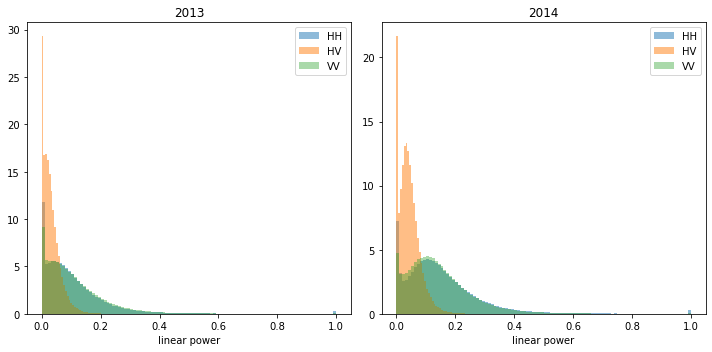

In [5]:
n = 100
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)

polarization = ['HH', 'HV', 'VV']

ax1.hist(np.clip(HH2013.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HH')
ax1.hist(np.clip(HV2013.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HV')
ax1.hist(np.clip(VV2013.ravel(),0,1), density=True, bins=n, alpha=0.4, label='VV')
ax1.set_title('2013')
ax1.legend(prop={'size': 10})
ax1.set_xlabel('linear power')

ax2.hist(np.clip(HH2014.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HH')
ax2.hist(np.clip(HV2014.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HV')
ax2.hist(np.clip(VV2014.ravel(),0,1), density=True, bins=n, alpha=0.4, label='VV')
ax2.set_title('2014')
ax2.legend(prop={'size': 10})
ax2.set_xlabel('linear power')

fig.tight_layout()
plt.show()

### 3. Plot each image

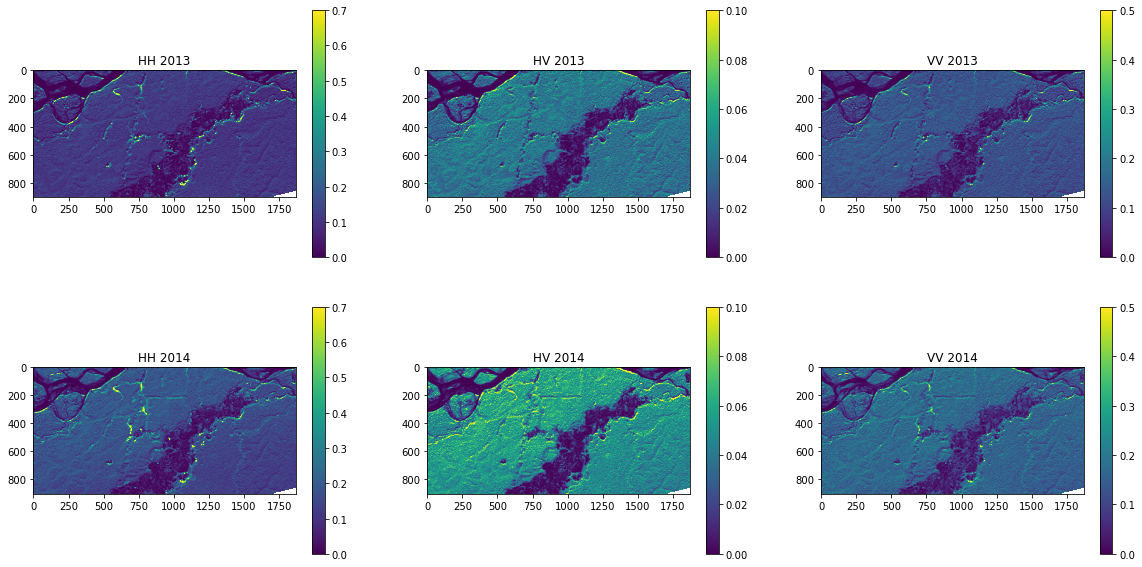

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

## 2014 ##
cm = ['viridis']
color = ax[0,0].imshow(HH2013, vmin=0, vmax=0.7, cmap=cm[0])
ax[0,0].set_title('HH 2013')
fig.colorbar(color, ax=ax[0,0])

color = ax[0,1].imshow(HV2013, vmin=0, vmax=0.1, cmap=cm[0])
ax[0,1].set_title('HV 2013')
fig.colorbar(color, ax=ax[0,1])

color = ax[0,2].imshow(VV2013, vmin=0, vmax=0.5, cmap=cm[0])
ax[0,2].set_title('VV 2013')
fig.colorbar(color, ax=ax[0,2])


## 2017 ##
color = ax[1,0].imshow(HH2014, vmin=0, vmax=0.7, cmap=cm[0])
ax[1,0].set_title('HH 2014')
fig.colorbar(color, ax=ax[1,0])

color = ax[1,1].imshow(HV2014, vmin=0, vmax=0.1, cmap=cm[0])
ax[1,1].set_title('HV 2014')
fig.colorbar(color, ax=ax[1,1])

color = ax[1,2].imshow(VV2014, vmin=0, vmax=0.5, cmap=cm[0])
ax[1,2].set_title('VV 2014')
fig.colorbar(color, ax=ax[1,2])

### 4a. Remove outliers from images using the median and standard devation

In [7]:
def reject_outliers(data, m=0.5):
    data[abs(data - np.nanmedian(data)) > m * np.nanstd(data)] = 0
    return data

HH2013_outlier = reject_outliers(HH2013)
HV2013_outlier = reject_outliers(HV2013)
VV2013_outlier = reject_outliers(VV2013)

HH2014_outlier = reject_outliers(HH2014)
HV2014_outlier = reject_outliers(HV2014)
VV2014_outlier = reject_outliers(VV2014)

### 4b. Scale images 0 to 1

In [8]:
def scale(data):
    minimum = np.nanmin(data)
    maximum = np.nanmax(data)
    data = ((data - minimum) * (1/maximum - minimum))
    return data

HH2013_scaled = scale(HH2013_outlier)
HV2013_scaled = scale(HV2013_outlier)
VV2013_scaled = scale(VV2013_outlier)

HH2014_scaled = scale(HH2014_outlier)
HV2014_scaled = scale(HV2014_outlier)
VV2014_scaled = scale(VV2014_outlier)

### 5. Create RGB Composite
Red = HH
Green = HV
Blue = VV

Text(0.5, 1.0, '2013 RGB')

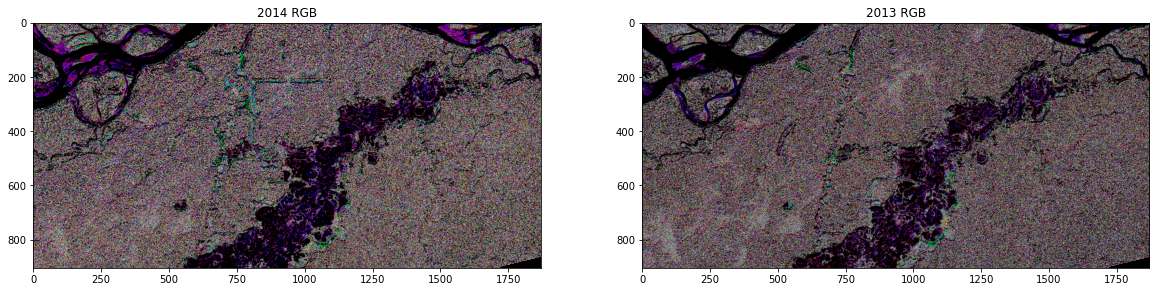

In [9]:
rgb_2014 = np.stack((HH2014_scaled, HV2014_scaled, VV2014_scaled), axis=2)
rgb_2013 = np.stack((HH2013_scaled, HV2013_scaled, VV2013_scaled), axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb_2014)
ax1.set_title('2014 RGB')
ax2.imshow(rgb_2013)
ax2.set_title('2013 RGB')

# Napa Valley Deforestation

### 1. Read in UAVSAR data

In [64]:
data_dir = Path('./uavsar_data')
cropped_tifs = sorted(list(data_dir.glob('./SanAnd*cropped*.tif')))

def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, cropped_tifs))

HH2016 = bands[0]
HV2016 = bands[1]
VV2016 = bands[2]

HH2017 = bands[3]
HV2017 = bands[4]
VV2017 = bands[5]

### 2. Plot the histogram of the UAVSAR data. 
The units are linear power. 

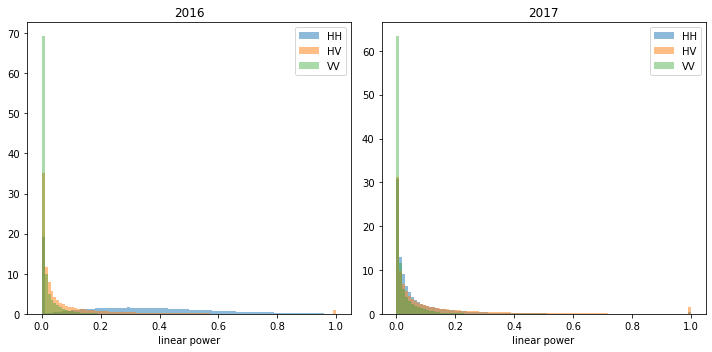

In [65]:
n = 100
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)

polarization = ['HH', 'HV', 'VV']

ax1.hist(np.clip(HH2016.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HH')
ax1.hist(np.clip(HV2016.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HV')
ax1.hist(np.clip(VV2016.ravel(),0,1), density=True, bins=n, alpha=0.4, label='VV')
ax1.set_title('2016')
ax1.legend(prop={'size': 10})
ax1.set_xlabel('linear power')

ax2.hist(np.clip(HH2017.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HH')
ax2.hist(np.clip(HV2017.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HV')
ax2.hist(np.clip(VV2017.ravel(),0,1), density=True, bins=n, alpha=0.4, label='VV')
ax2.set_title('2017')
ax2.legend(prop={'size': 10})
ax2.set_xlabel('linear power')

fig.tight_layout()
plt.show()

### 3. Plot each image

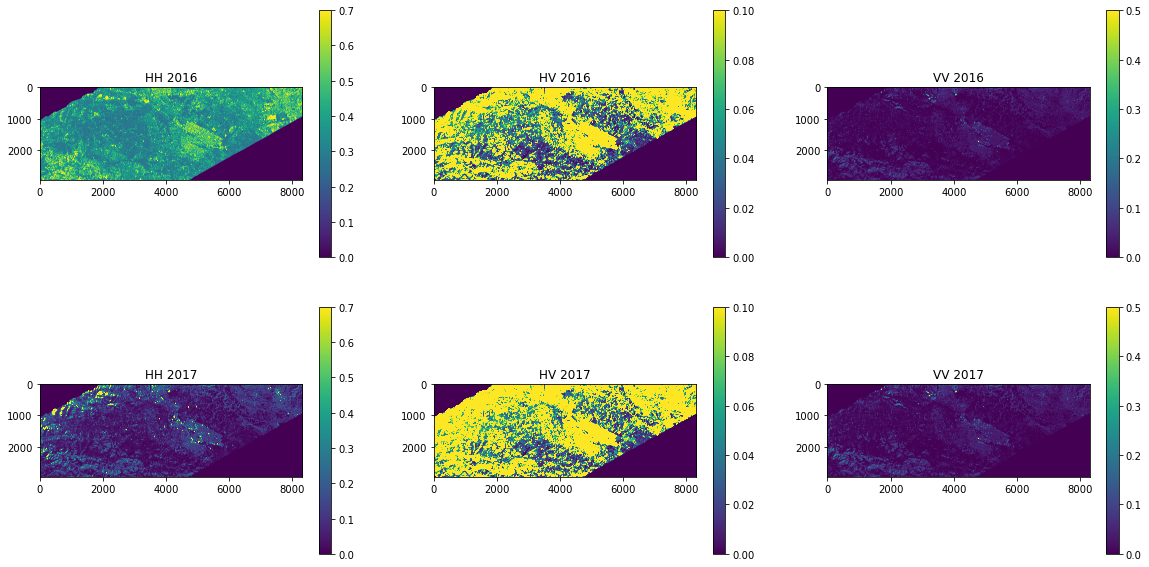

In [66]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

## 2016 ##
cm = ['viridis']
color = ax[0,0].imshow(HH2016, vmin=0, vmax=0.7, cmap=cm[0])
ax[0,0].set_title('HH 2016')
fig.colorbar(color, ax=ax[0,0])

color = ax[0,1].imshow(HV2016, vmin=0, vmax=0.1, cmap=cm[0])
ax[0,1].set_title('HV 2016')
fig.colorbar(color, ax=ax[0,1])

color = ax[0,2].imshow(VV2016, vmin=0, vmax=0.5, cmap=cm[0])
ax[0,2].set_title('VV 2016')
fig.colorbar(color, ax=ax[0,2])


## 2017 ##
color = ax[1,0].imshow(HH2017, vmin=0, vmax=0.7, cmap=cm[0])
ax[1,0].set_title('HH 2017')
fig.colorbar(color, ax=ax[1,0])

color = ax[1,1].imshow(HV2017, vmin=0, vmax=0.1, cmap=cm[0])
ax[1,1].set_title('HV 2017')
fig.colorbar(color, ax=ax[1,1])

color = ax[1,2].imshow(VV2017, vmin=0, vmax=0.5, cmap=cm[0])
ax[1,2].set_title('VV 2017')
fig.colorbar(color, ax=ax[1,2])

### 4a. Remove outliers from images using the median and standard devation

In [69]:
def reject_outliers(data, m=0.1):
    data[abs(data - np.nanmedian(data)) > m * np.nanstd(data)] = 0
    return data

HH2016_outlier = reject_outliers(HH2016)
HV2016_outlier = reject_outliers(HV2016)
VV2016_outlier = reject_outliers(VV2016)

HH2017_outlier = reject_outliers(HH2017)
HV2017_outlier = reject_outliers(HV2017)
VV2017_outlier = reject_outliers(VV2017)

### 4b. Scale images 0 to 1

In [70]:
def scale(data):
    minimum = np.nanmin(data)
    maximum = np.nanmax(data)
    data = ((data - minimum) * (1/maximum - minimum))
    return data

HH2016_scaled = scale(HH2016_outlier)
HV2016_scaled = scale(HV2016_outlier)
VV2016_scaled = scale(VV2016_outlier)

HH2017_scaled = scale(HH2017_outlier)
HV2017_scaled = scale(HV2017_outlier)
VV2017_scaled = scale(VV2017_outlier)

### 5. Create RGB Composite
Red = HH
Green = HV
Blue = VV

Text(0.5, 1.0, '2017 RGB')

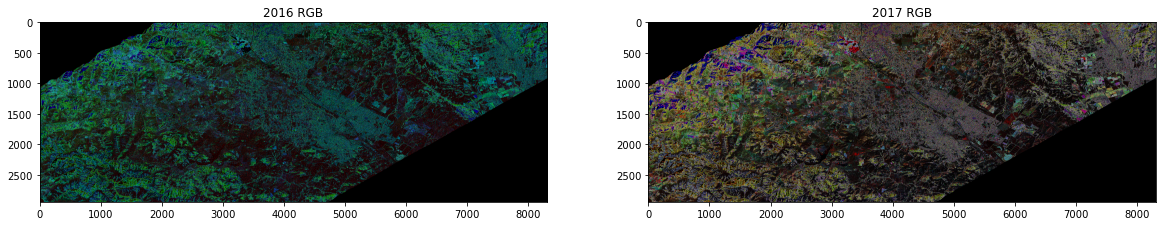

In [71]:
rgb_2016 = np.stack((HH2016_scaled, HV2016_scaled, VV2016_scaled), axis=2)
rgb_2017 = np.stack((HH2017_scaled, HV2017_scaled, VV2017_scaled), axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb_2016)
ax1.set_title('2016 RGB')
ax2.imshow(rgb_2017)
ax2.set_title('2017 RGB')

# Napa InSAR Coherence

### 1. Read in and plot coherence image

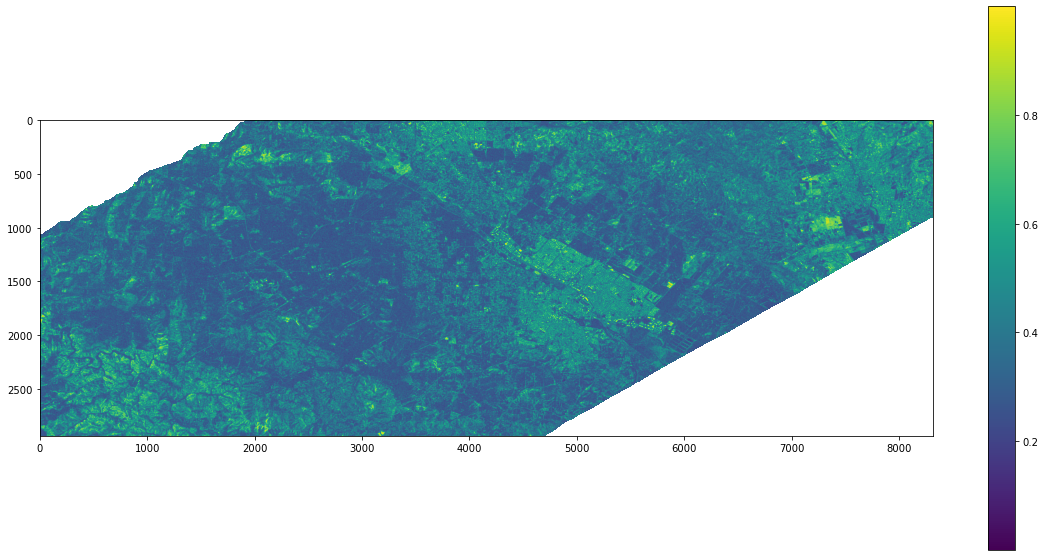

In [79]:
#data_dir = Path('./uavsar_data')
#fp = sorted(list(data_dir.glob('./SanAnd*cropped.cor.grd.tif')))
fp = '/Users/peacock/Desktop/UAVSAR_Quicklooks/leaflet_test/Forest_Disturbance/uavsar_data/SanAnd_23513_16034-006_17021-002_0343d_s01_L090HH_01_cropped.cor.grd.tif'

raster = rasterio.open(fp)
coherence = raster.read(1)
coherence[coherence==0] = np.nan ## Set 0 as nodata

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(coherence)
plt.colorbar()

### 2. Plot coherence histogram

Text(0.5, 0, 'coherence')

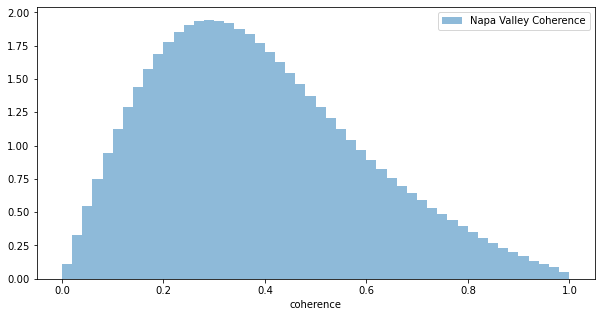

In [80]:
plt.subplots(figsize=(10,5))
plt.hist(coherence.ravel(),bins=50, density=True, label='Napa Valley Coherence', alpha=.5)
plt.legend()
plt.xlabel('coherence')

### 3. Thresholding

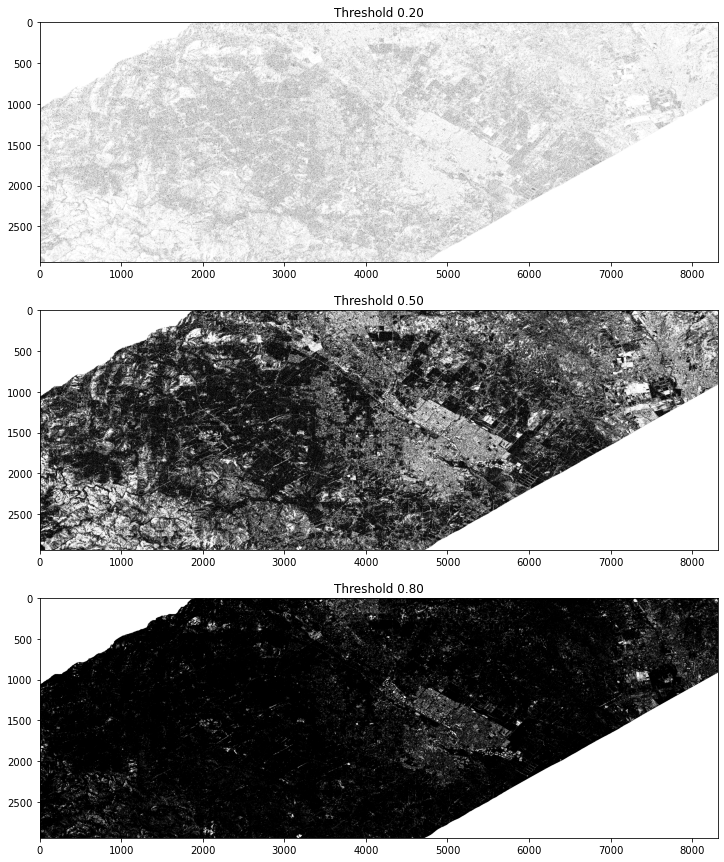

In [81]:
N=3
thresh_arr = np.linspace(0.2, 0.8, N)
fig, ax = plt.subplots(N, 1, figsize=(30, 15))
for ax, thresh in zip(ax.ravel(), thresh_arr):
    ax.imshow(coherence < thresh, cmap="Greys")
    ax.set_title(f'Threshold {thresh:1.2f}')
    

# Mammoth Tree Dieoff

### 1. Read in UAVSAR Data

In [57]:
data_dir = Path('./uavsar_data')
cropped_tifs = sorted(list(data_dir.glob('./lngvly*cropped.grd.tif')))

def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, cropped_tifs))

HH_mammoth = bands[0]
HV_mammoth = bands[1]
VV_mammoth = bands[2]

### 2. Plot the histogram of the UAVSAR data. 
The units are linear power. 

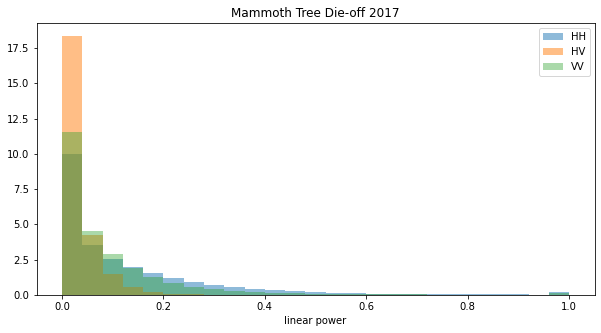

In [58]:
n = 25
fig, ax = plt.subplots(figsize=(10,5))

polarization = ['HH', 'HV', 'VV']

ax.hist(np.clip(HH_mammoth.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HH')
ax.hist(np.clip(HV_mammoth.ravel(),0,1), density=True, bins=n, alpha=0.5, label='HV')
ax.hist(np.clip(VV_mammoth.ravel(),0,1), density=True, bins=n, alpha=0.4, label='VV')
ax.set_title('Mammoth Tree Die-off 2017')
ax.legend(prop={'size': 10})
ax.set_xlabel('linear power')

plt.show()

### 3. Plot each polarization

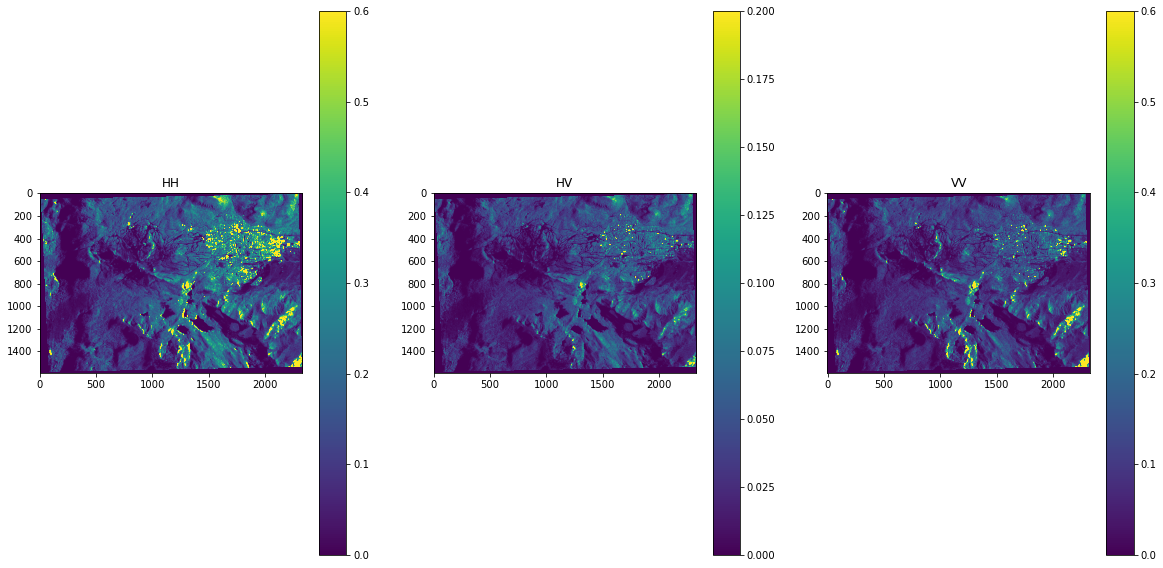

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

color = ax1.imshow(HH_mammoth, vmin=0, vmax=0.6)
ax1.set_title('HH')
fig.colorbar(color, ax=ax1)

color = ax2.imshow(HV_mammoth, vmin=0, vmax=0.2)
ax2.set_title('HV')
fig.colorbar(color, ax=ax2)

color = ax3.imshow(VV_mammoth, vmin=0, vmax=0.6)
ax3.set_title('VV')
fig.colorbar(color, ax=ax3)

### 4a. Remove outliers from images using the median and standard devation

In [60]:
def reject_outliers(data, m=2):
    data[abs(data - np.nanmedian(data)) > m * np.nanstd(data)] = 0
    return data

HH_outlier = reject_outliers(HH_mammoth)
HV_outlier = reject_outliers(HV_mammoth)
VV_outlier = reject_outliers(VV_mammoth)

### 4b. Scale images 0 to 1

In [61]:
def scale(data):
    minimum = np.nanmin(data)
    maximum = np.nanmax(data)
    data = ((data - minimum) * (1/maximum - minimum))
    return data

HH_scaled = scale(HH_outlier)
HV_scaled = scale(HV_outlier)
VV_scaled = scale(VV_outlier)

### 5. Create RGB Composite
Red = HH
Green = HV
Blue = VV

Text(0.5, 1.0, 'Mammoth RGB')

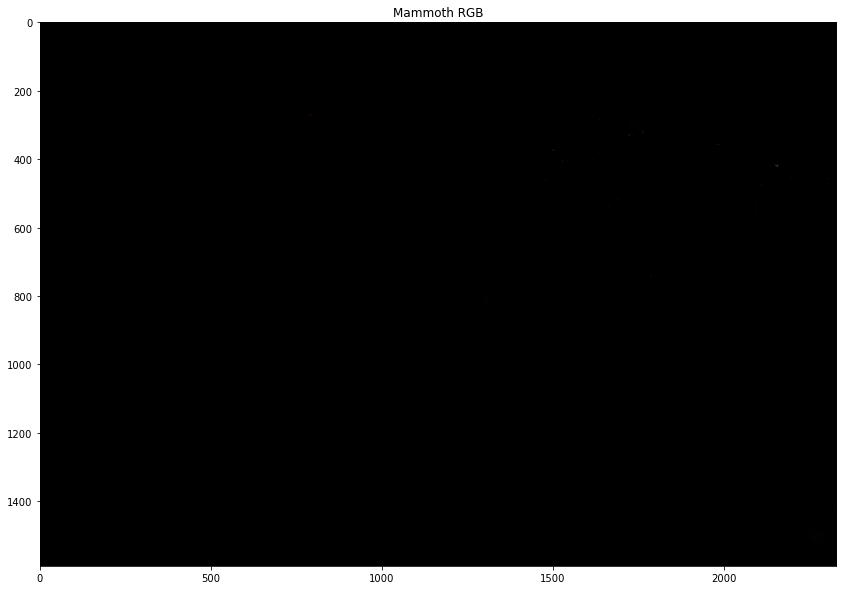

In [62]:
rgb = np.stack((HH_scaled, HV_scaled, VV_scaled), axis=2)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(rgb)
ax.set_title('Mammoth RGB')